<a href="https://colab.research.google.com/github/gimenopea/CachedHE/blob/main/PraxisScalingTests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update -qq
!apt-get install -y -qq libopenmpi-dev openmpi-bin
!pip install --quiet mpi4py phe numpy tenseal


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.3/466.3 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 81.0 MB/s eta 0:00:00


In [ ]:
%%writefile mpi_paillier_scaling_both.py

from mpi4py import MPI
import numpy as np
from phe import paillier
import csv, os, math

# --- Uncached Encryption ---
def encryption_experiment_uncached(comm, total_numbers, public_key):
    rank = comm.Get_rank()
    size = comm.Get_size()
    data = np.arange(1, total_numbers+1, dtype='int') if rank==0 else None
    chunk_size = total_numbers // size
    chunk = np.empty(chunk_size, dtype='int')
    comm.Scatter(data, chunk, root=0)
    start = MPI.Wtime()
    local_enc = [ public_key.encrypt(int(x)) for x in chunk ]
    enc_time = MPI.Wtime() - start
    return enc_time, local_enc

# --- Cached (Rache) Encryption ---
def build_cache(public_key, max_value):
    bit_len = max_value.bit_length()
    start = MPI.Wtime()
    radices = [ public_key.encrypt(2**i) for i in range(bit_len) ]
    zero_cipher = public_key.encrypt(0)
    cache_time = MPI.Wtime() - start
    return cache_time, radices, zero_cipher

def encryption_experiment_cached(comm, total_numbers, radices, zero_cipher):
    rank = comm.Get_rank()
    size = comm.Get_size()
    data = np.arange(1, total_numbers+1, dtype='int') if rank==0 else None
    chunk_size = total_numbers // size
    chunk = np.empty(chunk_size, dtype='int')
    comm.Scatter(data, chunk, root=0)
    start = MPI.Wtime()
    local_enc = []
    for x in chunk:
        c = zero_cipher
        for j, rct in enumerate(radices):
            if (x >> j) & 1:
                c = c + rct
        local_enc.append(c)
    enc_time = MPI.Wtime() - start
    return enc_time, local_enc

# --- Homomorphic Addition (shared) ---
def homomorphic_addition_experiment(comm, local_encrypted, private_key):
    start = MPI.Wtime()
    total = local_encrypted[0]
    for ct in local_encrypted[1:]: total = total + ct
    gathered = comm.gather(total, root=0)
    if comm.Get_rank()==0:
        agg = gathered[0]
        for s in gathered[1:]: agg = agg + s
        dec = private_key.decrypt(agg)
    else:
        dec = None
    add_time = MPI.Wtime() - start
    return add_time, dec

# --- Run per-method experiment ---
def run_experiment(method, exp_cores, total_numbers, public_key, private_key, world, iterations=1):
    rank = world.Get_rank(); size = world.Get_size()
    if size < exp_cores: return None
    color = 0 if rank<exp_cores else MPI.UNDEFINED
    sub = world.Split(color, rank)
    if sub == MPI.COMM_NULL: return None
    # init for cached
    cache_time = None; radices = None; zero_cipher = None
    if method=='cached' and sub.Get_rank()==0:
        cache_time, radices, zero_cipher = build_cache(public_key, total_numbers)
    if method=='cached':
        cache_time = sub.bcast(cache_time, root=0)
        radices   = sub.bcast(radices,   root=0)
        zero_cipher = sub.bcast(zero_cipher, root=0)
    enc_times, add_times, decs = [], [], []
    for _ in range(iterations):
        if method=='uncached':
            et, enc_chunk = encryption_experiment_uncached(sub, total_numbers, public_key)
        else:
            et, enc_chunk = encryption_experiment_cached(sub, total_numbers, radices, zero_cipher)
        at, dec = homomorphic_addition_experiment(sub, enc_chunk, private_key)
        enc_times.append(et); add_times.append(at)
        if sub.Get_rank()==0: decs.append(dec)
    if sub.Get_rank()==0:
        expected = total_numbers*(total_numbers+1)//2
        accuracy = sum(d==expected for d in decs)/len(decs)
        return {
            'method': method,
            'cores': exp_cores,
            'total_numbers': total_numbers,
            'cache_time': cache_time,
            'avg_enc': np.mean(enc_times), 'std_enc': np.std(enc_times),
            'avg_add': np.mean(add_times), 'std_add': np.std(add_times),
            'accuracy': accuracy
        }
    return None

# --- Main: strong & weak scaling for both methods ---
def main():
    world = MPI.COMM_WORLD; rank = world.Get_rank(); size = world.Get_size()
    strong_total = 32768; weak_per = 8192
    core_counts = [4,8,16,32]; key_sizes=[1024]; iterations=1
    results=[]
    if rank==0: print("== Paillier: Strong & Weak Scaling (cached vs uncached) - 1024-bit, 1 iter ==")
    for n_bits in key_sizes:
        if rank==0: print(f"\n-- Key size: {n_bits} bits --")
        if rank==0: pub, priv = paillier.generate_paillier_keypair(n_length=n_bits)
        else: pub=priv=None
        pub = world.bcast(pub,root=0); priv = world.bcast(priv,root=0)
        for scenario in ['strong','weak']:
            total_base = strong_total if scenario=='strong' else weak_per
            for c in core_counts:
                total = total_base if scenario=='strong' else weak_per*c
                for method in ['uncached','cached']:
                    res = run_experiment(method, c, total, pub, priv, world, iterations)
                    if rank==0 and res:
                        res.update({'key_size':n_bits,'scenario':scenario})
                        results.append(res)
                if rank==0 and size < c:
                    print(f"Skipping {c} cores (only {size} avail)")
    if rank==0 and results:
        path="paillier_scaling_both.csv"
        with open(path,'w',newline='') as f:
            writer=csv.DictWriter(f,fieldnames=[
                'method','key_size','scenario','cores','total_numbers',
                'cache_time','avg_enc','std_enc','avg_add','std_add','accuracy'
            ])
            writer.writeheader(); writer.writerows(results)
        print(f"Results written to {path}")

if __name__=='__main__':
    main()


Overwriting mpi_paillier_scaling_both.py


In [ ]:
!mpirun --allow-run-as-root -np 32 python mpi_paillier_scaling_both.py

== Paillier: Strong & Weak Scaling (cached vs uncached) - 1024-bit, 1 iter ==

-- Key size: 1024 bits --
Results written to paillier_scaling_both.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("paillier_scaling_both.csv")

# Split scenarios
strong = df[df["scenario"] == "strong"]
weak   = df[df["scenario"] == "weak"]

# --- Strong scaling plot ---
plt.figure()
for method in ["uncached", "cached"]:
    sub = strong[strong["method"] == method].set_index("cores").sort_index()
    plt.plot(sub.index, sub["avg_enc"], marker="o", label=method)
plt.xlabel("Number of Cores")
plt.ylabel("Average Encryption Time (s)")
plt.title("Strong Scaling: Paillier Encryption")
plt.legend()
plt.grid(True)
plt.savefig("strong_scaling_paillier.png", dpi=300)
plt.close()

# --- Weak scaling plot ---
plt.figure()
for method in ["uncached", "cached"]:
    sub = weak[weak["method"] == method].set_index("cores").sort_index()
    plt.plot(sub.index, sub["avg_enc"], marker="o", label=method)
plt.xlabel("Number of Cores")
plt.ylabel("Average Encryption Time (s)")
plt.title("Weak Scaling: Paillier Encryption")
plt.legend()
plt.grid(True)
plt.savefig("weak_scaling_paillier.png", dpi=300)
plt.close()

print("Saved strong_scaling_paillier.png and weak_scaling_paillier.png")


Saved strong_scaling_paillier.png and weak_scaling_paillier.png


In [ ]:
%%writefile mpi_tenseal_bfv_scaling_both.py

from mpi4py import MPI
import numpy as np
import tenseal as ts
import csv

# --- BFV Uncached Encryption ---
def encryption_experiment_uncached(comm, total_numbers, ctx):
    rank, size = comm.Get_rank(), comm.Get_size()
    data = np.arange(1, total_numbers+1, dtype='int') if rank==0 else None
    chunk_size = total_numbers // size
    chunk = np.empty(chunk_size, dtype='int')
    comm.Scatter(data, chunk, root=0)
    start = MPI.Wtime()
    local_ct = [ts.bfv_vector(ctx, [int(x)]) for x in chunk]
    enc_time = MPI.Wtime() - start
    return enc_time, local_ct

# --- BFV Cached (Rache-style) Encryption ---
def build_cache(ctx, total_numbers):
    bit_len = total_numbers.bit_length()
    start = MPI.Wtime()
    radices = [ts.bfv_vector(ctx, [2**i]) for i in range(bit_len)]
    zero_cipher = ts.bfv_vector(ctx, [0])
    cache_time = MPI.Wtime() - start
    return cache_time, radices, zero_cipher

def encryption_experiment_cached(comm, total_numbers, radices, zero_cipher):
    rank, size = comm.Get_rank(), comm.Get_size()
    data = np.arange(1, total_numbers+1, dtype='int') if rank==0 else None
    chunk_size = total_numbers // size
    chunk = np.empty(chunk_size, dtype='int')
    comm.Scatter(data, chunk, root=0)
    start = MPI.Wtime()
    local_ct = []
    for x in chunk:
        c = zero_cipher
        for j, rct in enumerate(radices):
            if (x >> j) & 1:
                c = c + rct
        local_ct.append(c)
    enc_time = MPI.Wtime() - start
    return enc_time, local_ct

# --- Homomorphic Addition (shared) ---
def homomorphic_addition_experiment(comm, local_ct, ctx, plain_modulus):
    start = MPI.Wtime()
    s = local_ct[0]
    for ct in local_ct[1:]: s += ct
    serialized = s.serialize()
    collected = comm.gather(serialized, root=0)
    if comm.Get_rank()==0:
        final = ts.bfv_vector_from(ctx, collected[0])
        for ser in collected[1:]: final += ts.bfv_vector_from(ctx, ser)
        dec = final.decrypt()[0]
        dec_mod = dec if dec>=0 else dec + plain_modulus
    else:
        dec_mod = None
    add_time = MPI.Wtime() - start
    return add_time, dec_mod

# --- Run one experiment (uncached or cached) ---
def run_experiment(method, exp_cores, total_numbers, ctx, plain_modulus, world_comm, iterations, key_size):
    rank, size = world_comm.Get_rank(), world_comm.Get_size()
    if size < exp_cores:
        return None
    color = 0 if rank<exp_cores else MPI.UNDEFINED
    sub = world_comm.Split(color, rank)
    if sub==MPI.COMM_NULL:
        return None

    # build cache on each process to avoid pickling
    if method=='cached':
        cache_time, radices, zero_cipher = build_cache(ctx, total_numbers)
    else:
        cache_time, radices, zero_cipher = None, None, None

    enc_times, add_times, decs = [], [], []
    for _ in range(iterations):
        if method=='uncached':
            et, ct_list = encryption_experiment_uncached(sub, total_numbers, ctx)
        else:
            et, ct_list = encryption_experiment_cached(sub, total_numbers, radices, zero_cipher)
        at, dec = homomorphic_addition_experiment(sub, ct_list, ctx, plain_modulus)
        enc_times.append(et)
        add_times.append(at)
        if sub.Get_rank()==0: decs.append(dec)

    if sub.Get_rank()==0:
        expected = total_numbers*(total_numbers+1)//2
        accuracy = sum(d==expected for d in decs)/len(decs)
        return {
            'method': method,
            'key_size': key_size,
            'cores': exp_cores,
            'total_numbers': total_numbers,
            'cache_time': cache_time,
            'avg_enc': np.mean(enc_times),
            'std_enc': np.std(enc_times),
            'avg_add': np.mean(add_times),
            'std_add': np.std(add_times),
            'accuracy': accuracy
        }
    return None

# --- Main: strong & weak scaling for a single BFV setting ---
def main():
    world = MPI.COMM_WORLD
    rank, size = world.Get_rank(), world.Get_size()

    strong_total = 32768
    weak_per = 8192
    core_counts = [4, 8, 16, 32]
    iterations = 1

    # Only use the 8192-degree, [40,40,40], 1024-bit equivalent setting
    poly_deg, coeff_bits, key_size = 8192, [40, 40, 40], 1024

    if rank==0:
        print(f"== BFV tenSEAL Scaling: key_size={key_size}, iterations={iterations} ==")
        results=[]

    # Setup context once
    if rank==0:
        ctx = ts.context(
            ts.SCHEME_TYPE.BFV,
            poly_modulus_degree=poly_deg,
            plain_modulus=536903681,
            coeff_mod_bit_sizes=coeff_bits
        )
        serialized = ctx.serialize(save_secret_key=True)
    else:
        serialized = None
    serialized = world.bcast(serialized, root=0)
    ctx = ts.context_from(serialized)
    plain_modulus = world.bcast(536903681, root=0)

    for scenario in ['strong','weak']:
        base = strong_total if scenario=='strong' else weak_per
        for c in core_counts:
            total = base if scenario=='strong' else weak_per*c
            for method in ['uncached','cached']:
                res = run_experiment(method, c, total, ctx, plain_modulus, world, iterations, key_size)
                if rank==0 and res:
                    res['scenario']=scenario
                    results.append(res)
            if rank==0 and size<c:
                print(f"Skipping {c} cores (only {size} avail)")

    if rank==0:
        path='bfv_scaling_both.csv'
        with open(path,'w',newline='') as f:
            writer=csv.DictWriter(f,fieldnames=[
                'method','key_size','scenario','cores','total_numbers',
                'cache_time','avg_enc','std_enc','avg_add','std_add','accuracy'
            ])
            writer.writeheader()
            writer.writerows(results)
        print(f"Results written to {path}")

if __name__=='__main__':
    main()


Overwriting mpi_tenseal_bfv_scaling_both.py


In [ ]:
!mpirun --allow-run-as-root -np 32 python mpi_tenseal_bfv_scaling_both.py

== BFV tenSEAL Scaling: key_size=1024, iterations=1 ==
Results written to bfv_scaling_both.csv


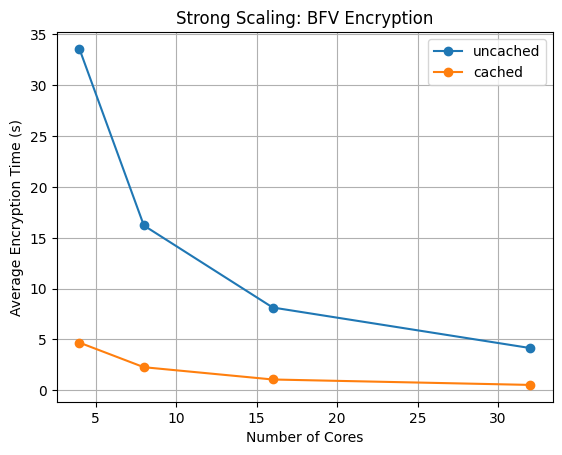

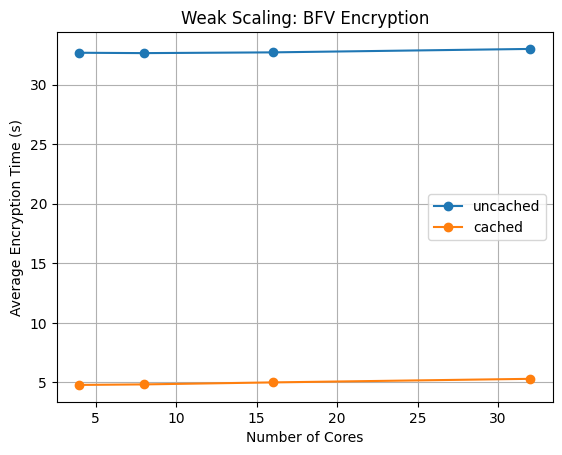

Saved strong_scaling_bfv.png and weak_scaling_bfv.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load BFV scaling results
df = pd.read_csv('bfv_scaling_both.csv')

# Split scenarios
strong = df[df['scenario'] == 'strong']
weak   = df[df['scenario'] == 'weak']

# --- Strong scaling plot ---
plt.figure()
for method in ['uncached', 'cached']:
    sub = strong[strong['method'] == method].set_index('cores').sort_index()
    plt.plot(sub.index, sub['avg_enc'], marker='o', label=method)
plt.xlabel('Number of Cores')
plt.ylabel('Average Encryption Time (s)')
plt.title('Strong Scaling: BFV Encryption')
plt.legend()
plt.grid(True)
plt.savefig('strong_scaling_bfv.png', dpi=300)
plt.show()

# --- Weak scaling plot ---
plt.figure()
for method in ['uncached', 'cached']:
    sub = weak[weak['method'] == method].set_index('cores').sort_index()
    plt.plot(sub.index, sub['avg_enc'], marker='o', label=method)
plt.xlabel('Number of Cores')
plt.ylabel('Average Encryption Time (s)')
plt.title('Weak Scaling: BFV Encryption')
plt.legend()
plt.grid(True)
plt.savefig('weak_scaling_bfv.png', dpi=300)
plt.show()

print("Saved strong_scaling_bfv.png and weak_scaling_bfv.png")


In [ ]:
%%writefile mpi_tenseal_ckks_scaling_both.py

from mpi4py import MPI
import numpy as np
import tenseal as ts
import csv

# --- CKKS Uncached Encryption ---
def encryption_experiment_uncached(comm, total_numbers, ctx):
    rank, size = comm.Get_rank(), comm.Get_size()
    data = np.arange(1, total_numbers + 1, dtype='int') if rank == 0 else None
    chunk_size = total_numbers // size
    chunk = np.empty(chunk_size, dtype='int')
    comm.Scatter(data, chunk, root=0)
    start = MPI.Wtime()
    local_ct = [ts.ckks_vector(ctx, [float(x)]) for x in chunk]
    enc_time = MPI.Wtime() - start
    return enc_time, local_ct

# --- CKKS Cached (Rache-style) Encryption ---
def build_cache(ctx, total_numbers):
    bit_len = total_numbers.bit_length()
    start = MPI.Wtime()
    radices = [ts.ckks_vector(ctx, [float(2**i)]) for i in range(bit_len)]
    zero_cipher = ts.ckks_vector(ctx, [0.0])
    cache_time = MPI.Wtime() - start
    return cache_time, radices, zero_cipher

def encryption_experiment_cached(comm, total_numbers, radices, zero_cipher):
    rank, size = comm.Get_rank(), comm.Get_size()
    data = np.arange(1, total_numbers + 1, dtype='int') if rank == 0 else None
    chunk_size = total_numbers // size
    chunk = np.empty(chunk_size, dtype='int')
    comm.Scatter(data, chunk, root=0)
    start = MPI.Wtime()
    local_ct = []
    for x in chunk:
        c = zero_cipher
        for j, rct in enumerate(radices):
            if (x >> j) & 1:
                c += rct
        local_ct.append(c)
    enc_time = MPI.Wtime() - start
    return enc_time, local_ct

# --- Homomorphic Addition (shared) ---
def homomorphic_addition_experiment(comm, local_ct, ctx):
    start = MPI.Wtime()
    s = local_ct[0]
    for ct in local_ct[1:]:
        s += ct
    serialized = s.serialize()
    collected = comm.gather(serialized, root=0)
    if comm.Get_rank() == 0:
        final = ts.ckks_vector_from(ctx, collected[0])
        for ser in collected[1:]:
            final += ts.ckks_vector_from(ctx, ser)
        dec = final.decrypt()[0]
    else:
        dec = None
    add_time = MPI.Wtime() - start
    return add_time, dec

# --- Run one experiment (uncached or cached) ---
def run_experiment(method, exp_cores, total_numbers, ctx, world_comm, iterations, poly_mod_degree):
    rank, size = world_comm.Get_rank(), world_comm.Get_size()
    if size < exp_cores:
        return None
    color = 0 if rank < exp_cores else MPI.UNDEFINED
    sub = world_comm.Split(color, rank)
    if sub == MPI.COMM_NULL:
        return None

    if method == 'cached':
        cache_time, radices, zero_cipher = build_cache(ctx, total_numbers)
    else:
        cache_time = None
        radices = zero_cipher = None

    enc_times, add_times, decs = [], [], []
    for _ in range(iterations):
        if method == 'uncached':
            et, ct_list = encryption_experiment_uncached(sub, total_numbers, ctx)
        else:
            et, ct_list = encryption_experiment_cached(sub, total_numbers, radices, zero_cipher)
        at, dec = homomorphic_addition_experiment(sub, ct_list, ctx)
        enc_times.append(et)
        add_times.append(at)
        if sub.Get_rank() == 0:
            decs.append(dec)

    if sub.Get_rank() == 0:
        expected = float(total_numbers * (total_numbers + 1) / 2)
        accuracy = sum(abs(d - expected) < 1e-3 for d in decs) / len(decs)
        return {
            'method': method,
            'poly_modulus_degree': poly_mod_degree,
            'cores': exp_cores,
            'total_numbers': total_numbers,
            'cache_time': cache_time,
            'avg_enc': np.mean(enc_times),
            'std_enc': np.std(enc_times),
            'avg_add': np.mean(add_times),
            'std_add': np.std(add_times),
            'accuracy': accuracy
        }
    return None

# --- Main: strong & weak scaling for CKKS ---
def main():
    world = MPI.COMM_WORLD
    rank, size = world.Get_rank(), world.Get_size()

    strong_total = 32768
    weak_per = 8192
    core_counts = [4, 8, 16, 32]
    iterations = 1

    # CKKS parameters
    poly_deg = 8192
    coeff_bits = [60, 40, 40, 60]
    global_scale = 2**25

    if rank == 0:
        print(f"== CKKS tenSEAL Scaling: poly_modulus_degree={poly_deg}, iterations={iterations} ==")
        results = []

    # Setup CKKS context once
    if rank == 0:
        ctx = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=poly_deg,
            coeff_mod_bit_sizes=coeff_bits
        )
        ctx.global_scale = global_scale
        serialized = ctx.serialize(save_secret_key=True)
    else:
        serialized = None
    serialized = world.bcast(serialized, root=0)
    ctx = ts.context_from(serialized)

    for scenario in ['strong', 'weak']:
        base = strong_total if scenario == 'strong' else weak_per
        for c in core_counts:
            total = base if scenario == 'strong' else weak_per * c
            for method in ['uncached', 'cached']:
                res = run_experiment(method, c, total, ctx, world, iterations, poly_deg)
                if rank == 0 and res:
                    res['scenario'] = scenario
                    results.append(res)
            if rank == 0 and size < c:
                print(f"Skipping {c} cores (only {size} avail)")

    if rank == 0:
        path = 'ckks_scaling_both.csv'
        with open(path, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=[
                'method', 'poly_modulus_degree', 'scenario', 'cores', 'total_numbers',
                'cache_time', 'avg_enc', 'std_enc', 'avg_add', 'std_add', 'accuracy'
            ])
            writer.writeheader()
            writer.writerows(results)
        print(f"Results written to {path}")

if __name__ == '__main__':
    main()


Overwriting mpi_tenseal_ckks_scaling_both.py


In [ ]:
!mpirun --allow-run-as-root -np 32 python mpi_tenseal_ckks_scaling_both.py

== CKKS tenSEAL Scaling: poly_modulus_degree=8192, iterations=1 ==
Results written to ckks_scaling_both.csv


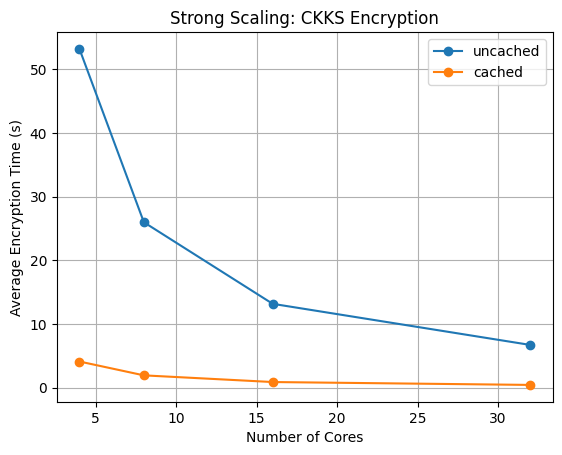

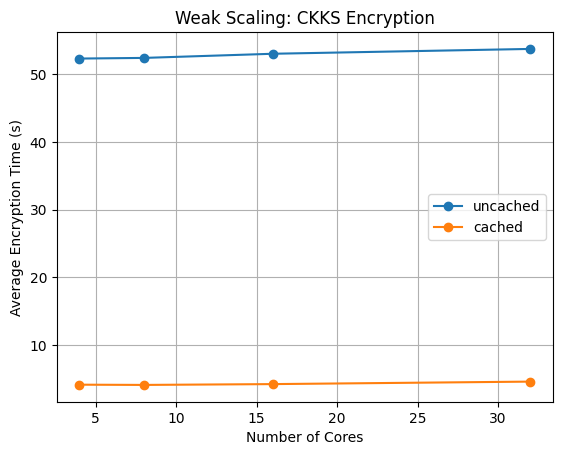

Saved strong_scaling_ckks.png and weak_scaling_ckks.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CKKS scaling results
df = pd.read_csv('ckks_scaling_both.csv')

# Split scenarios
strong = df[df['scenario'] == 'strong']
weak   = df[df['scenario'] == 'weak']

# --- Strong scaling plot ---
plt.figure()
for method in ['uncached', 'cached']:
    sub = strong[strong['method'] == method].set_index('cores').sort_index()
    plt.plot(sub.index, sub['avg_enc'], marker='o', label=method)
plt.xlabel('Number of Cores')
plt.ylabel('Average Encryption Time (s)')
plt.title('Strong Scaling: CKKS Encryption')
plt.legend()
plt.grid(True)
plt.savefig('strong_scaling_ckks.png', dpi=300)
plt.show()

# --- Weak scaling plot ---
plt.figure()
for method in ['uncached', 'cached']:
    sub = weak[weak['method'] == method].set_index('cores').sort_index()
    plt.plot(sub.index, sub['avg_enc'], marker='o', label=method)
plt.xlabel('Number of Cores')
plt.ylabel('Average Encryption Time (s)')
plt.title('Weak Scaling: CKKS Encryption')
plt.legend()
plt.grid(True)
plt.savefig('weak_scaling_ckks.png', dpi=300)
plt.show()

print("Saved strong_scaling_ckks.png and weak_scaling_ckks.png")
